<a href="https://colab.research.google.com/github/matthew-lyr/other_stuffs/blob/main/VAE_%2B_Discriminator_on_MINST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch; 
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [ ]:
nc = 1
ndf = 3

class Discriminator(nn.Module):
    def __init__(self, ngpu = 1):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, 10, 7, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
def train_without_discriminator(autoencoder, data, epochs=20):
    opt_vae = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
          # train vae by optimizing reconstruction loss
            x = x.to(device) # GPU
            opt_vae.zero_grad()
            x_hat = autoencoder(x)
            reconstruction_loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            reconstruction_loss.backward()
            opt_vae.step()

    return autoencoder


def train(autoencoder, discriminator, data, epochs=20):
    opt_vae = torch.optim.Adam(autoencoder.parameters())
    opt_d   = torch.optim.Adam(discriminator.parameters())
    for epoch in range(epochs):
        for x, y in data:
          # train vae by optimizing reconstruction loss
            x = x.to(device) # GPU
            y = y.to(device) # GPU
            opt_vae.zero_grad()
            x_hat = autoencoder(x)
            reconstruction_loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            reconstruction_loss.backward()
            opt_vae.step()

          # train discriminator
            opt_d.zero_grad()
            output_from_real_pics = discriminator(x)
            crossEntropyLoss = nn.CrossEntropyLoss()
            classification_loss_for_training_discriminatro = crossEntropyLoss(output_from_real_pics.squeeze(2).squeeze(2), y)
            classification_loss_for_training_discriminatro.backward()
            opt_d.step()

          # train vae by optimizing classification loss
            opt_vae.zero_grad()
            opt_d.zero_grad()
            x_hat = autoencoder(x)
            output_from_reconstructed_pics = discriminator(x_hat)
            classification_loss_for_training_vae = crossEntropyLoss(output_from_reconstructed_pics.squeeze(2).squeeze(2), y)
            classification_loss_for_training_vae.backward()
            opt_vae.step()

    return autoencoder, discriminator

In [ ]:
latent_dims = 2

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

data2 = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [25]:
vae           = VariationalAutoencoder(latent_dims).to(device) # GPU
discriminator = Discriminator().to(device)
vae, discriminator = train(vae, discriminator, data, epochs=50)


vae_without_discriminator = VariationalAutoencoder(latent_dims).to(device) # GPU
vae_without_discriminator = train_without_discriminator(vae_without_discriminator, data2, epochs=50)

In [108]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=10):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

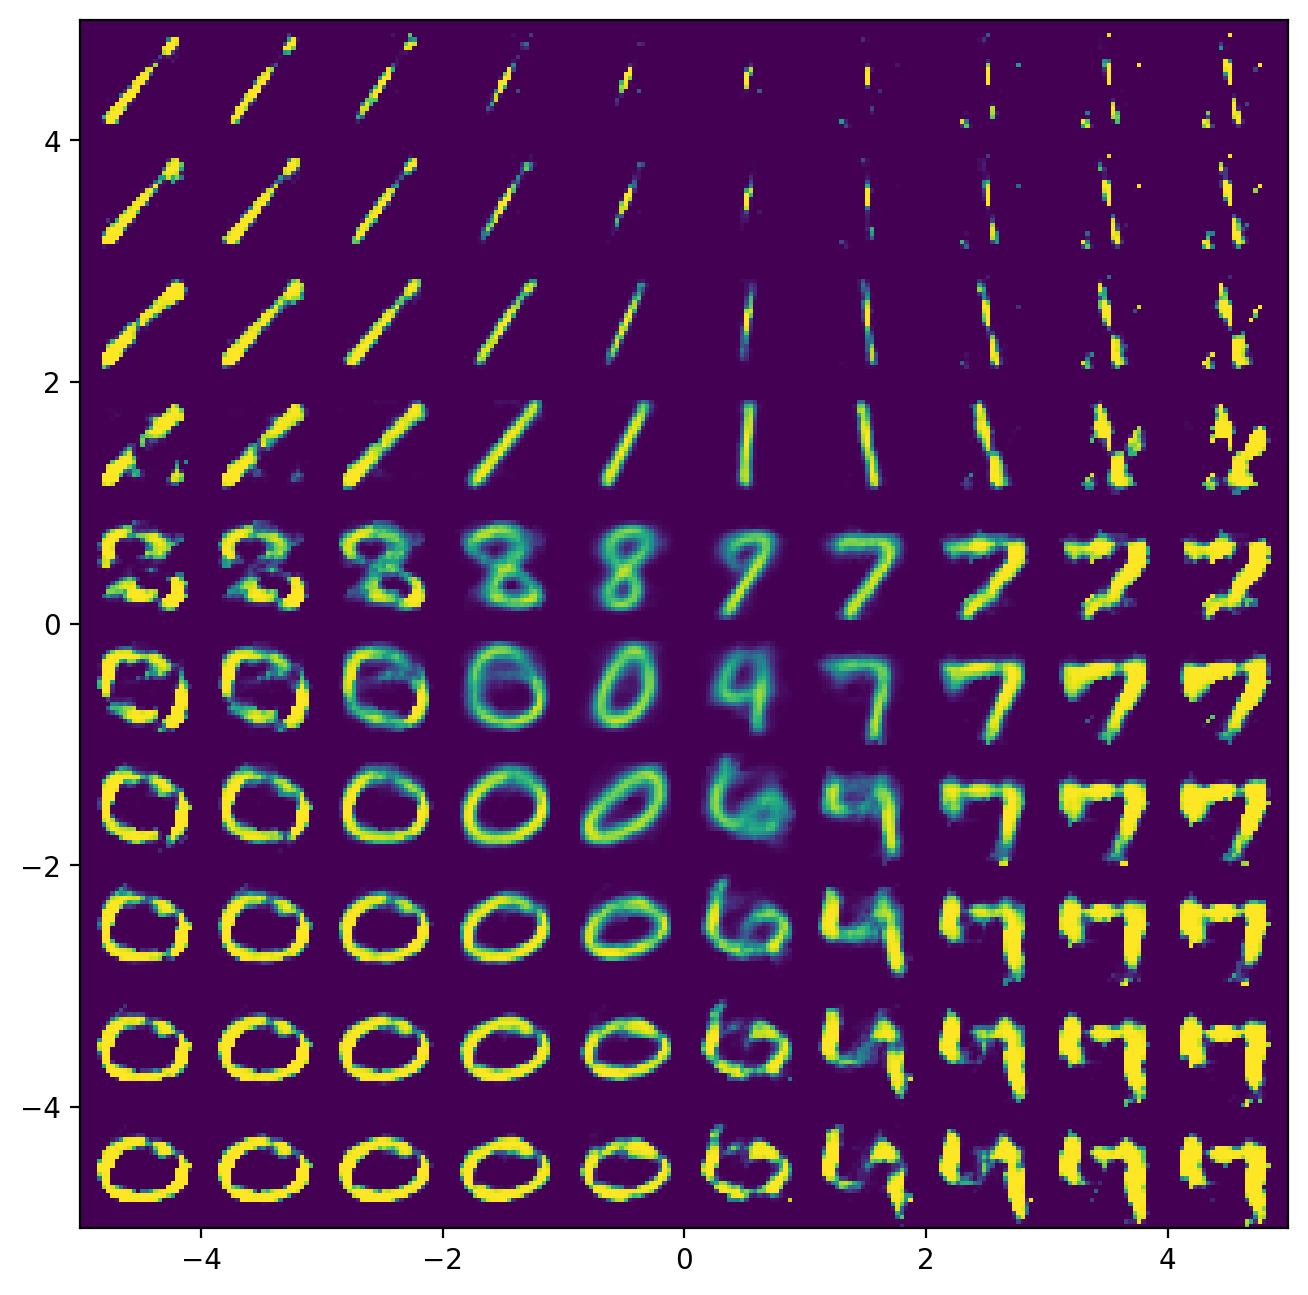

In [109]:
# after
plot_reconstructed(vae,  r0=(-5, 5), r1=(-5, 5))

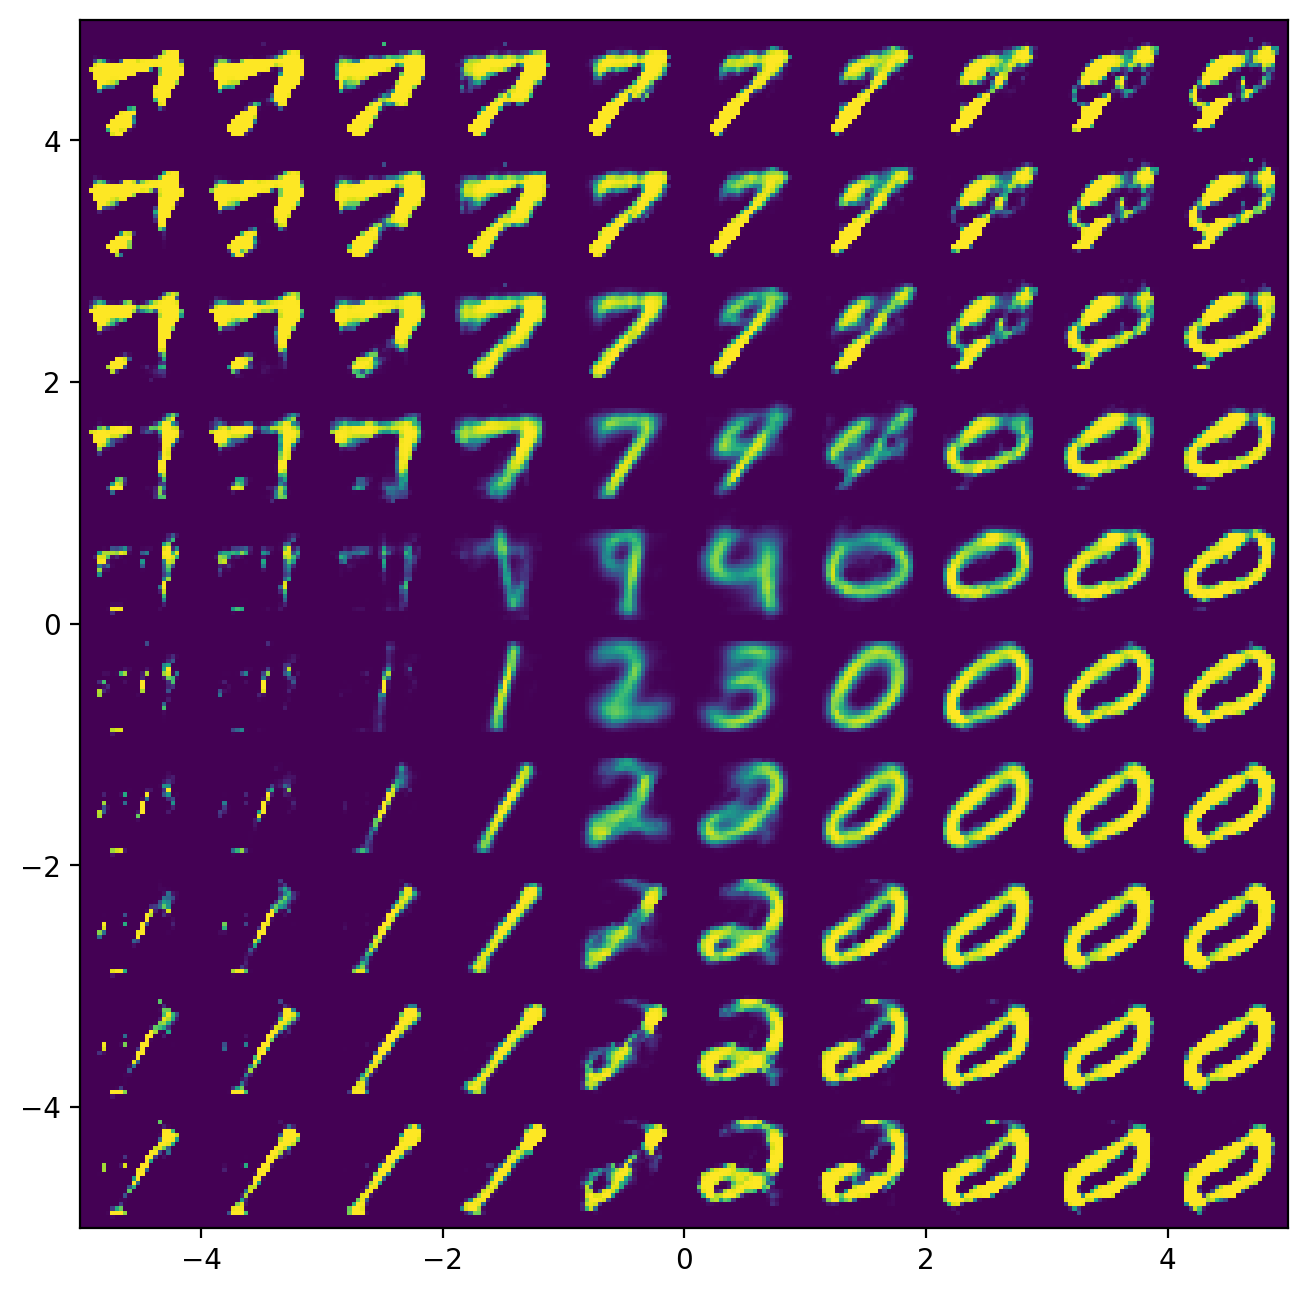

In [110]:
# before
plot_reconstructed(vae_without_discriminator,  r0=(-5, 5), r1=(-5, 5))

In [65]:
image, y = iter(data).next()
image.shape

torch.Size([128, 1, 28, 28])

In [74]:
print(discriminator(image.to(device))[1])
print(y[1])

tensor([[[-0.0701]],

        [[-3.1424]],

        [[-1.6660]],

        [[-1.5048]],

        [[ 2.5798]],

        [[ 2.4572]],

        [[26.6680]],

        [[-4.1587]],

        [[-0.7556]],

        [[-1.6010]]], device='cuda:0', grad_fn=<SelectBackward>)
tensor(6)
